In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import shutil
from sklearn.model_selection import train_test_split
from transformers import AutoProcessor, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from transformers import CLIPModel, CLIPProcessor
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

e:\repos\CLIP_multimodal_search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

### 1. Работа с данными

In [2]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image']
        description = self.data.iloc[idx]['description']
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, description

In [3]:
dataset = FashionDataset(
    csv_file='archive/data.csv',
    images_dir='archive/data',
    transform=transforms.ToTensor()
)

#### Несколько картинок из датасета с описаниями

Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only


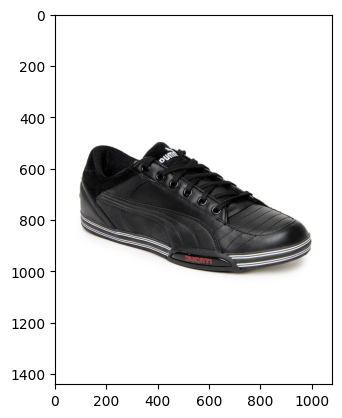

In [4]:
image, label = dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))
print(label)

Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit


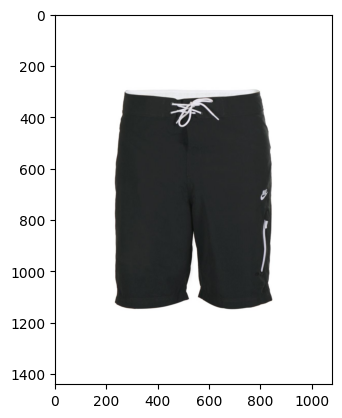

In [5]:
image, label = dataset.__getitem__(1)
plt.imshow(image.permute(1, 2, 0))
print(label)

Teal  handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket  and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back


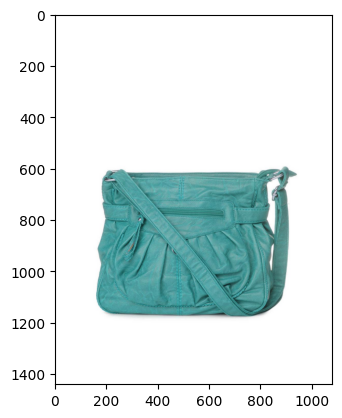

In [6]:
image, label = dataset.__getitem__(2)
plt.imshow(image.permute(1, 2, 0))
print(label)

#### Разрешение картинок

In [7]:
image.size()

torch.Size([3, 1440, 1080])

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = FashionDataset(
    csv_file='archive/data.csv',
    images_dir='archive/data',
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
)

In [ ]:
from collections import Counter

def preprocess_data(csv_file, images_dir, output_dir='cleaned_data'):
    # Создаем директорию для очищенных данных
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    
    # Загружаем данные
    df = pd.read_csv(csv_file)
    
    print(f"Исходный размер датасета: {len(df)}")
    
    # Удаляем строки с пустыми значениями в нужных столбцах
    df_cleaned = df.dropna(subset=['image', 'description'])
    print(f"После удаления пустых значений: {len(df_cleaned)}")
    
    # Удаляем дубликаты по названию изображения
    df_cleaned = df_cleaned.drop_duplicates(subset=['image'])
    print(f"После удаления дубликатов по изображению: {len(df_cleaned)}")
    
    # Удаляем дубликаты по описанию (если нужно более строго)
    df_cleaned = df_cleaned.drop_duplicates(subset=['description'])
    print(f"После удаления дубликатов по описанию: {len(df_cleaned)}")
    
    # Проверяем существование файлов изображений
    valid_rows = []
    missing_images = []
    
    for idx, row in df_cleaned.iterrows():
        img_path = os.path.join(images_dir, row['image'])
        if os.path.exists(img_path):
            valid_rows.append(row)
        else:
            missing_images.append(row['image'])
    
    df_final = pd.DataFrame(valid_rows)
    print(f"После проверки существования изображений: {len(df_final)}")
    print(f"Отсутствующие изображения: {len(missing_images)}")
    
    # Проверяем категории перед стратификацией
    if 'category' in df_final.columns:
        category_counts = Counter(df_final['category'])
        print("\nРаспределение по категориям:")
        for category, count in category_counts.most_common():
            print(f"  {category}: {count} samples")
        
        # Фильтруем категории с менее чем 2 элементами
        valid_categories = [cat for cat, count in category_counts.items() if count >= 2]
        df_stratify = df_final[df_final['category'].isin(valid_categories)]
        df_no_stratify = df_final[~df_final['category'].isin(valid_categories)]
        
        print(f"\nДанные для стратификации: {len(df_stratify)}")
        print(f"Данные без стратификации: {len(df_no_stratify)}")
        
        if len(df_stratify) > 0:
            # Разделяем с стратификацией
            train_strat, test_strat = train_test_split(
                df_stratify, 
                test_size=0.1, 
                random_state=42,
                stratify=df_stratify['category']
            )
        else:
            train_strat, test_strat = pd.DataFrame(), pd.DataFrame()
        
        # Разделяем данные без стратификации
        if len(df_no_stratify) > 0:
            train_no_strat, test_no_strat = train_test_split(
                df_no_stratify,
                test_size=0.1,
                random_state=42,
                shuffle=True
            )
        else:
            train_no_strat, test_no_strat = pd.DataFrame(), pd.DataFrame()
        
        # Объединяем результаты
        train_df = pd.concat([train_strat, train_no_strat], ignore_index=True)
        test_df = pd.concat([test_strat, test_no_strat], ignore_index=True)
        
    else:
        # Если колонки category нет, разделяем без стратификации
        train_df, test_df = train_test_split(
            df_final, 
            test_size=0.1, 
            random_state=42,
            shuffle=True
        )
    
    print(f"Train размер: {len(train_df)}")
    print(f"Test размер: {len(test_df)}")
    
    # def copy_images(df, split_name):
    #     split_dir = os.path.join(output_dir, split_name)
    #     os.makedirs(split_dir, exist_ok=True)
    #     os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
        
    #     for _, row in df.iterrows():
    #         src_path = os.path.join(images_dir, row['image'])
    #         dst_path = os.path.join(split_dir, 'images', row['image'])
    #         shutil.copy2(src_path, dst_path)
        
    #     # Сохраняем CSV файл
    #     df.to_csv(os.path.join(split_dir, f'{split_name}.csv'), index=False)
    
    # copy_images(train_df, 'train')
    # copy_images(test_df, 'test')
    
    # # Сохраняем общий очищенный датасет
    # df_final.to_csv(os.path.join(output_dir, 'cleaned_data.csv'), index=False)
    
    return train_df, test_df

# Запускаем предобработку
train_df, test_df = preprocess_data('archive/data.csv', 'archive/data')

Исходный размер датасета: 44441
После удаления пустых значений: 44160
После удаления дубликатов по изображению: 44160
После удаления дубликатов по описанию: 38856
После проверки существования изображений: 38856
Отсутствующие изображения: 0

Распределение по категориям:
  Tshirts: 6428 samples
  Shirts: 2886 samples
  Casual Shoes: 2370 samples
  Watches: 2223 samples
  Kurtas: 1727 samples
  Sports Shoes: 1707 samples
  Tops: 1634 samples
  Handbags: 1570 samples
  Heels: 1164 samples
  Wallets: 806 samples
  Briefs: 791 samples
  Sunglasses: 784 samples
  Sandals: 742 samples
  Flip Flops: 710 samples
  Belts: 686 samples
  Backpacks: 657 samples
  Socks: 594 samples
  Perfume and Body Mist: 568 samples
  Formal Shoes: 550 samples
  Jeans: 543 samples
  Shorts: 503 samples
  Trousers: 485 samples
  Bra: 439 samples
  Dresses: 433 samples
  Sarees: 413 samples
  Earrings: 406 samples
  Flats: 394 samples
  Deodorant: 327 samples
  Track Pants: 290 samples
  Sweatshirts: 283 samples
  S

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionDataset(
    csv_file='cleaned_data/train/data.csv',
    images_dir='cleaned_data/train/data',
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
)

test_dataset = FashionDataset(
    csv_file='cleaned_data/test/data.csv',
    images_dir='cleaned_data/test/data',
    transform=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
)

### 2. Работа с моделью

In [11]:
model_name = "openai/clip-vit-base-patch32"
model = AutoModel.from_pretrained(model_name).to('cuda')
processor = AutoProcessor.from_pretrained(model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
images, texts = next(iter(test_dataloader))

In [13]:
texts

('An absolutely stylish casual shoe, this pair from numero uno is a great addition to your wardrobe. With a synthetic and suede combination, it creates a casual style statement. Team this with jeans and polo neck t-shirts for that smart look. Upper   Synthetic leather upper for durability and comfort  Suede toe box and lace-up lining for durability and style  Synthetic leather and suede overlays in wrap around pattern for midfoot support and structure  Lace-up system for snug, customized Fit  Long tongue for snug fit  Branding on lateral ankle and tongue for style   Midsole   Phylon midsole for all-day cushioned comfort  Padded sockliner for in-step comfort  Cabreel lining for easy and cushioned wear  Textured toe box foxing in durable rubber for forefoot protection and durability  Brand badge on lateral heel for style   Outsole   Durable rubber outsole in herringbone pattern for maximum durability and traction   shoe care Wipe synthetic leather surface with damp, clean cloth to remove

In [14]:
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True).to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
    clip_logit_score = outputs.logits_per_image

print("CLIP logit score:", clip_logit_score)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


CLIP logit score: tensor([[20.1120, 22.1520, 20.2340, 18.8909],
        [20.1557, 22.2570, 20.2899, 18.8858],
        [20.5291, 22.3889, 20.6103, 19.1211],
        [20.2055, 22.4001, 20.3462, 18.8535]], device='cuda:0')


In [15]:
img_emb = outputs.image_embeds  
txt_emb = outputs.text_embeds   

img_emb = torch.nn.functional.normalize(img_emb, dim=-1)
txt_emb = torch.nn.functional.normalize(txt_emb, dim=-1)

clip_scores = (img_emb * txt_emb).sum(dim=-1)

In [16]:
clip_scores

tensor([0.2011, 0.2226, 0.2061, 0.1885], device='cuda:0')

### 3. Дообучение

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def clip_loss(logits_per_image, logits_per_text):
    labels = torch.arange(logits_per_image.shape[0]).to(logits_per_image.device)
    loss_img = nn.CrossEntropyLoss()(logits_per_image, labels)
    loss_txt = nn.CrossEntropyLoss()(logits_per_text, labels)
    return (loss_img + loss_txt) / 2

def calculate_clip_score(logits_per_image):
    predictions = logits_per_image.argmax(dim=1)
    labels = torch.arange(logits_per_image.shape[0]).to(logits_per_image.device)
    correct = (predictions == labels).sum().item()
    return correct / logits_per_image.shape[0] * 100  # в процентах

In [ ]:
class CLIPTrainer:
    def __init__(self, model, processor, train_loader, val_loader, device):
        self.model = model.to(device)
        self.processor = processor
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        
        self.optimizer = optim.AdamW(
            self.model.parameters(), 
            lr=5e-5,
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=10)
        
        self.train_losses = []
        self.train_scores = []
        self.val_scores = []
        
    def train_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        total_score = 0
        num_batches = 0
        
        pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1} Training')
        
        for batch_idx, (images, texts) in enumerate(pbar):
            # Подготавливаем данные
            inputs = self.processor(
                text=texts, 
                images=images, 
                return_tensors="pt", 
                padding=True,
                truncation=True,
                max_length=77
            )
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Forward pass
            outputs = self.model(**inputs)
            
            # Вычисляем потери
            loss = clip_loss(outputs.logits_per_image, outputs.logits_per_text)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Вычисляем метрики
            score = calculate_clip_score(outputs.logits_per_image)
            
            total_loss += loss.item()
            total_score += score
            num_batches += 1
            
            # Логируем каждый батч
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'CLIP Score': f'{score:.2f}%'
            })
            
            # Сохраняем для визуализации
            if batch_idx % 10 == 0:
                self.train_losses.append(loss.item())
                self.train_scores.append(score)
        
        avg_loss = total_loss / num_batches
        avg_score = total_score / num_batches
        
        return avg_loss, avg_score
    
    def validate(self):
        self.model.eval()
        total_score = 0
        num_batches = 0
        
        with torch.no_grad():
            for images, texts in tqdm(self.val_loader, desc='Validation'):
                inputs = self.processor(
                    text=texts, 
                    images=images, 
                    return_tensors="pt", 
                    padding=True
                )
                inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
                outputs = self.model(**inputs)
                score = calculate_clip_score(outputs.logits_per_image)
                
                total_score += score
                num_batches += 1
        
        avg_score = total_score / num_batches
        return avg_score
    
    def save_checkpoint(self, epoch, path):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'train_scores': self.train_scores,
            'val_scores': self.val_scores
        }
        torch.save(checkpoint, path)
        print(f"Checkpoint saved: {path}")
    
    def load_checkpoint(self, path):
        """Загружает чекпоинт модели"""
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.train_losses = checkpoint['train_losses']
        self.train_scores = checkpoint['train_scores']
        self.val_scores = checkpoint['val_scores']
        print(f"Checkpoint loaded: {path}")
        return checkpoint['epoch']
    
    def train(self, num_epochs, checkpoint_dir='checkpoints'):
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        print("Starting training...")
        for epoch in range(num_epochs):
            # Обучение
            train_loss, train_score = self.train_epoch(epoch)
            
            # Валидация
            val_score = self.validate()
            self.val_scores.append(val_score)
            
            # Обновление scheduler
            self.scheduler.step()
            
            # Логирование эпохи
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train CLIP Score: {train_score:.2f}%")
            print(f"Val CLIP Score: {val_score:.2f}%")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.2e}")
            
            # Сохранение чекпоинта
            checkpoint_path = os.path.join(checkpoint_dir, f'clip_epoch_{epoch+1}.pth')
            self.save_checkpoint(epoch, checkpoint_path)
            
            # Ранняя остановка если достигли целевого значения
            if val_score >= 30:
                print(f"Target achieved! Val CLIP Score: {val_score:.2f}%")
                break
    
    def plot_training_curves(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curve
        ax1.plot(self.train_losses)
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Batch (every 10th)')
        ax1.set_ylabel('Loss')
        ax1.grid(True)
        
        # CLIP Score curves
        epochs = range(1, len(self.val_scores) + 1)
        ax2.plot(epochs, self.train_scores[-len(self.val_scores):], label='Train Score')
        ax2.plot(epochs, self.val_scores, label='Val Score')
        ax2.set_title('CLIP Score')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Score (%)')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

In [25]:
# Инициализация тренера
trainer = CLIPTrainer(model, processor, train_dataloader, test_dataloader, device)

# Обучение
num_epochs = 4
trainer.train(num_epochs)

# Визуализация результатов
trainer.plot_training_curves()

Starting training...


Validation:   0%|          | 0/972 [00:00<?, ?it/s]


ValueError: Sequence length must be less than max_position_embeddings (got `sequence length`: 175 and max_position_embeddings: 77